Created on friday 15 January 2021

**Group 5 - Classification  
General semi supervised vf**

@authors : Lilian Dulinge

**Methodology :**  
The general goal of our sub-group was to predict whether a document speaks of a given theme (innovation or management range). For this, we have for each topic a list of keywords related to the topics that allows us to define which words to search if we want to find documents talking about these topics. We have therefore defined functions that allow us to classify articles that we are sure they speak about the theme and words that we are sure do not speak of the theme thanks to a thresholding system based on the appearance of keywords in the text. Then we train supervised classification algorithms which take as input the texts already labeled and which predict the texts not labeled by our function. The most complicated task in this project was to define whether the labels we award are effective and relevant or not. We therefore analyzed the results of the different classifiers and their learning abilities with the predefined labels (we use the F1 score metric to define the quality of the classifiers) in order to keep only those who best understand the difference between the documents related to the topic. and those unrelated. In order not to encumber this document too much, I present only the first analyzes made on the V0, the others are present in the various notebooks. In order to evaluate the performance, we also create word clouds to see for each class which are the most common words in the texts. This allows us to see if the most common words correspond to the given lists or if they come close. These 2 combined analyzes allowed us to obtain a rather good and interesting implementation of the labels. To train our models we use features calculated by ourselves on the text in the V0 and for the V1 we use the representations of words in the documents such as Word2Vec or the bag of words given by the G3. The axes of improvement of our results were to improve the comparison between the list and the words in the text, to enrich the list (synonym, acronym), to improve our starting function and finally to improve our algorithms classification. Once we had all the labels, we could go to supervised with classic models to learn about them provided our labels were good.



# Import libraries

In [ ]:
import re
import nltk
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from tqdm import tqdm_notebook as tqdm
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Create link between drive and notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import data

In [ ]:
df: pd.DataFrame = pd.read_csv(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/Data_With_Features_Syntax.csv")

In [ ]:
df_final: pd.DataFrame = pd.read_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/df_final_clean.json")

df: pd.DataFrame = pd.merge(left=df, right=df_final,
                            left_on='art_id', right_on='art_id')

In [ ]:
art_lemma: pd.DataFrame = pd.read_json(
    '/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/df_articles_lemma.json')

df: pd.DataFrame = pd.merge(
    left=df, right=art_lemma, left_on='art_id', right_on='art_lemma_id')

In [ ]:
df_lexique: pd.DataFrame = pd.read_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/df_lexique_lemma.json")

In [ ]:
bow: pd.DataFrame = pd.read_json(
    '/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/g3_BOW_v1.json')
data: pd.DataFrame = pd.read_csv(
    '/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/Data_With_Features_Syntax.csv')
df: pd.DataFrame = pd.merge(left=bow, right=data, on='art_id')
art_lemma: pd.DataFrame = pd.read_json(
    '/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/df_articles_lemma.json')
df: pd.DataFrame = pd.merge(
    left=df, right=art_lemma, left_on='art_id', right_on='art_lemma_id')

In [ ]:
df_lexique_innovation: pd.DataFrame = pd.read_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/df_lexique_lemma.json")

df_lexique_gestion: pd.DataFrame = pd.read_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/df_lexique_gammes_gestion.json")

# Functions for the 2 methods

## General

In [ ]:
# This function calculate numbers of words present in each documents
def nb_word(text: list) -> int:
    """Documentation
    Parameters:
        text: Texts of the article

    Out (if exists):
        nb_word: Number of word in  the document
    """
    # Counts the number of words
    nb_words: list = []
    nb: int = 0

    # Browse through the different texts
    for i in text:
        # Removes special characters
        i.replace(',', ' ')
        i.replace('.', ' ')
        i.replace('!', ' ')
        i.replace('?', ' ')
        i.replace('/', ' ')
        # Creates a list with all the words present in the text
        list_words: list = i.split()
        # Counts the number of words present in the text
        nb_words.append(len(list_words))

    return nb_words

In [ ]:
# This function calculate the numbers of key words given by a list in the documents
def count_key_words(data: pd.DataFrame, l: list) -> list:
    """Documentation
    Parameters:
        data: List of articles
        l: List of word that we will check in the sentences

    Out:
        res: List where each value is the number of time where key word appear in the article
    """
    list_mot_unique: list = []
    list_mot_compose: list = []

    # Count the number of time where the words in the list appear
    for elem in l:
        cpt: int = 0
        for car in elem:
            if (car == " "):
                cpt += 1
        if cpt == 0:
            list_mot_unique.append(elem)
        else:
            list_mot_compose.append(elem)

    res: list = []
    for i in tqdm(range(len(data))):
        sentence: str = data[i]
        if sentence is None:
            res.append(0)
        else:
            sentence = sentence.lower()
            sentence = sentence.split()
            t: int = 0
            for j in sentence:
                if (j in list(list_mot_unique)):
                    t = t + 1
            sentence: str = data[i]
            for elem in list_mot_compose:
                if elem in sentence:
                    t = t + 1
        res.append(t)

    return res

In [ ]:
# This function calculate the numbers of sentences in each documents
def sentences(data: pd.DataFrame, col: str) -> list:
    """Documentation
    Parameters:
        data: Dataframe with all the data
        columns: The columns of the dataframe that we will use

    Out:
        l: List where each value is the number of sentence in a article
    """
    l: list = []

    # Count the number of sentence
    for i in range(len(data[col])):
        sentences: str = data[col][i]

        if not isinstance(sentences, str):
            sentences: str = str(sentences)
        if (sentences is None):
            count_sentence.append(0)
        else:
            sentences = sentences.replace("..", ".")
            sentences = sentences.replace("...", ".")
            sentences = sentences.replace("!", ".")
            sentences = sentences.replace("!!", ".")
            sentences = sentences.replace("!!!", ".")
            sentences = sentences.replace("?", ".")
            sentences = sentences.replace("??", ".")
            sentences = sentences.replace("???", ".")
            sentences = sentences.replace("?!", ".")
            sentences = sentences.replace("!?", ".")
            l.append(len(sent_tokenize(sentences)))

    return l

## Innovation

In [ ]:
# Function to tell if a document is innovative
def innovation(data_nb1: pd.DataFrame, data_nb2: pd.DataFrame, data_ratio1: pd.DataFrame, data_ratio2: pd.DataFrame) -> list:
    """Documentation
    Parameters:
        data_nb1: First column of a dataframe who describe a number of key words presents in text
        data_nb2: Second column of a dataframe who describe a number of key words presents in title
        data_ratio1: Linked column of data_nb1 who represents a ratio of key word apparition in text
        data_ratio2: Linked column of data_nb2 who represents a ratio of ley word apparition in title

    Out:
        list: Represents whether a document is innovative or not (i.e. yes = 1, no = 0, don't know = ?)
    """
    res: list = []
    seuil: float = 0.05

    # The higher score show innovant document and the weakest show document who don't talk about innovation
    for i in tqdm(range(len(data_nb1))):
        valeur: float = data_nb1[i]*data_ratio1[i] + \
            (data_nb2[i]*data_ratio2[i])
        # We define a threshold and the document who have a score higher of this threshold take a 1 who represent innovation
        if valeur > seuil:
            res.append(1)
        # Documents whith little score are consider such as non innovant take 0
        elif ((valeur < seuil) & (data_nb1[i] == 0) & (data_nb2[i] == 0)):
            res.append(0)
        elif ((valeur < seuil) & (data_ratio1[i] < 0.0002) & (data_nb2[i] < 0.0005)):
            res.append(0)
        # The others have a '?' because we don't know if they are innovant or not and we try in the rest of notebooks to create labels
        else:
            res.append('?')

    return res

## Word cloud 

In [ ]:
# Function to clean our data before posting them
def preprocessing(sentence: str) -> str:
    """Documentation
    Parameters:
        data: 1 column of a dataframe especially choose because we want a column who contain only text

    Out:
        liste_return: Liste of all the text of the dataframe return with preprocessing applied
    """
    stop_words: set = set(stopwords.words('french'))
    pattern: list = ['(', ')', ':', ';', ',', '&', '/',
                     '"', "'", '\n', '©', 'n°', '-', 'ludivine', 'bailly', 'christine', 'verdier', 'jstories', 'dernier', 'article',
                     'jvstories', 'fabien', 'geledan', 'dgs', 'semaine', 'avril', 'deuxieme', 'septembre',
                     'quels', 'pret', 'caroline', 'madame', 'mesdames', 'messieurs', 'monsieur', 'chere', 'martin', 'etaient',
                     'comme', 'grisot', 'lancashire', 'faire', 'plus', 'sans', 'octobre', 'frédérique', 'jean', 'mathieu',
                     'quand', 'rue', 'sylvain', 'decembre', 'blamer', 'situee', 'place',
                     'malgré', 'levée', 'étaie', 'mène', 'poursuivis', 'malgre', 'mesures', 'ère', 'malgré',
                     'journée', 'janvier', 'thématique', 'fncdg', 'autres', 'mot', 'art_content', 'jouclas',
                     'tout', 'égal', 'quelle', 'dtype', 'object', 'length', 'name', ' ob', ' publiqu ', 'ibune',
                     'créé', 'taille', 'face', 'après', 'dessous', 'deuxième', ' nt', 'dé ', 'co ',
                     'dix', 'utilisez', 'chamboule', 'postale', 'jv', 'aujourd', 'mar ',
                     'peut', 'cette', 'vols', 'finies', ' con ', ' ru', 'ifs', ' tr', 'mai',
                     'place', 'perdues', 'trois', 'lors', 'pres ', 'fpe', ' bra', ' th', 'date', 'heure',
                     'art_content_clean_without_lem', 'ans', 'épidémie', 'style', 'dark',
                     'masque', 'permis', 'toujours', 'télévision']

    if not isinstance(sentence, str):
        sentence: str = str(sentence)

    sentence: str = re.sub(r'\d', ' ', sentence)
    sentence: str = sentence.lower()

    for d in pattern:
        sentence: str = sentence.replace(d, " ")

    token_words: list = word_tokenize(sentence)
    filtre: type = [w for w in token_words if not w in stop_words]

    final_list: str = ""
    for word in filtre:
        final_list: str = final_list + word + " "

    return (final_list)

In [ ]:
# Generates a word cloud for an article
def wordcloud_art(text: str):
    """Documentation
    Parameters:
        text: The article that will be show on the word cloud
    """
    text: str = preprocessing(text)
    if len(text) > 0:
        wordcloud: str = WordCloud(relative_scaling=1.0,).generate(str(text))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
        plt.close()
    else:
        print("The article have a size of 0.")

In [ ]:
# Generates a word cloud from a list of articles
def wordcloud_list_art(text: list):
    """Documentation
    Parameters:
        text: The list of articles that will be show on the word cloud
    """
    list_articles: str = ""
    for i in range(len(text)):
        list_articles: str = list_articles + text[0]
    wordcloud_art(text)

# Method1 (v0):





This document is a first experience of semi supervised learning for predict if a document is consider as innovant or not. We define if a document is innovant or not for us with a function and we try to define if the others are (these don't classifie by the function). Else we return a document with all the features and the predictions for innovation.

## Charts


In [ ]:
# Visualization of a 2D point cloud with a PCA
def graph_2d(data: pd.DataFrame, prediction: list, dic_values: dict, transparency: float = 0.15):
    """Documentation
    Parameters:
        data: The data that will be show on the plot
        prediction: The prediction that will be used to make distinction bewteen the differents class on the plot
        dic_values: The signification of every values in the prediction
        transparency: The transparency of the points on the graph
    """
    # Normalisation
    components = data.shape[1]
    sc: StandardScaler = StandardScaler()
    X: ndarray = sc.fit_transform(data)

    # PCA
    pca: PCA = PCA(n_components=components)
    X: ndarray = pca.fit_transform(X)

    # Chart
    plt.title('Titre')
    for name_modal in dic_values:
        plt.scatter(X[prediction == dic_values[name_modal], 0], X[prediction ==
                                                                  dic_values[name_modal], 1], alpha=transparency, label=name_modal)
    plt.legend()

In [ ]:
# Visualization of a 3D point cloud with a PCA
def graph_3d(data: pd.DataFrame, prediction: list, axes: tuple = (0, 1, 2), opacity: int = 1):
    """Documentation
    Parameters:
        data: The data that will be show on the plot
        prediction: The prediction that will be used to make distinction bewteen the differents class on the plot
        axes: Axes to plot
        opacity: The transparency of the points on the graph
    """
    # Normalisation
    components = data.shape[1]
    sc: StandardScaler = StandardScaler()
    X: ndarray = sc.fit_transform(data)

    # PCA
    pca: PCA = PCA(n_components=components)
    X: ndarray = pca.fit_transform(X)

    # Chat
    data_plot: pd.DataFrame = pd.DataFrame(X)
    data_plot["prediction"] = prediction
    fig: Figure = px.scatter_3d(
        data_plot, x=0, y=1, z=2, color='prediction', opacity=0.5)
    fig.show()

# DataFrame

Implementation of features for predict the last labels

In [ ]:
df["nb_key_words"]: pd.DataFrame = count_key_words(
    df["art_lemma"], df_lexique["key_words_lemma"])
df["nb_key_words_title"]: pd.DataFrame = count_key_words(
    df["art_title"], df_lexique["key_words_lemma"])
df["nb_words"]: pd.DataFrame = nb_word(df['art_content_x'])
df["nb_words_title"]: pd.DataFrame = nb_word(df['art_title'])
df["nb_sentences"]: pd.DataFrame = sentences(df, 'art_content_x')
df["average_word_sentence"]: pd.DataFrame = df["nb_words"] / df["nb_sentences"]
df["ratio_word_title_on_word"]: pd.DataFrame = df["nb_words_title"] / df["nb_words"]
df['ratio_key_words']: pd.DataFrame = df['nb_key_words']/df['nb_words']
df['ratio_key_words']: pd.DataFrame = df['ratio_key_words'].fillna(0)
df['ratio_key_sentences']: pd.DataFrame = df['nb_key_words']/df['nb_sentences']
df['ratio_key_sentences']: pd.DataFrame = df['ratio_key_sentences'].fillna(0)
df['ratio_key_word_title']: pd.DataFrame = df['nb_key_words_title'] / \
    df['nb_words_title']
df['ratio_key_word_title']: pd.DataFrame = df['ratio_key_word_title'].fillna(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [ ]:
df['innovation_detection']: pd.DataFrame = innovation(
    df['Nb_key_words'], df['ratio_key_words'], df['Nb_key_words_title'], df['ratio_key_word_title'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [ ]:
df['innovation_detection'].value_counts()

?    5198
0    1924
1     411
Name: innovation_detection, dtype: int64

In [ ]:
df: pd.DataFrame = df.sample(frac=1, random_state=15).reset_index(drop=True)

In [ ]:
df['index']: pd.DataFrame = df.index

In [ ]:
var_useful: pd.DataFrame = df[['art_id', 'Nb_key_words', 'Nb_key_words_title',
                               'ratio_key_words', 'ratio_key_word_title', 'innovation_detection']]

In [ ]:
all: pd.DataFrame = var_useful[var_useful['innovation_detection'] != '?']
unlabeled: pd.DataFrame = var_useful[var_useful['innovation_detection'] == '?']

In [ ]:
print(str(len(df)), str(len(all)), str(len(unlabeled)))

7533 2335 5198


# Detection semi supervised 

See different models and choose the best

In [ ]:
# Create test and train file
trainData, testData = train_test_split(all, test_size=0.2)

X_train: pd.DataFrame = trainData.drop('innovation_detection', axis=1)
y_train: pd.DataFrame = trainData.innovation_detection

X_unlabeled: pd.DataFrame = unlabeled.drop('innovation_detection', axis=1)

X_test: pd.DataFrame = testData.drop('innovation_detection', axis=1)
y_test: pd.DataFrame = testData.innovation_detection

Text(0, 0.5, 'Count')

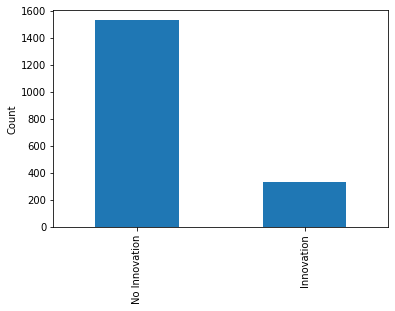

In [ ]:
# Graph of the number of innovative or non-innovative documents
y_train.value_counts().plot(kind='bar')
plt.xticks([0, 1], ['No Innovation', 'Innovation'])
plt.ylabel('Count')

In [ ]:
y_train: pd.DataFrame = pd.to_numeric(y_train)
y_test: pd.DataFrame = pd.to_numeric(y_test)

Train f1 Score: 0.9970238095238095
Test f1 Score: 0.9933774834437086


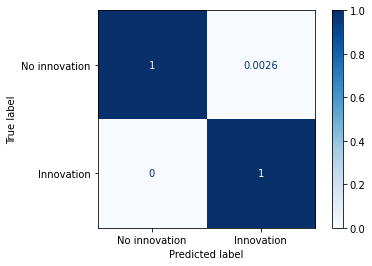

In [ ]:
# Logistic Regression Classifier
clf: LogisticRegression = LogisticRegression(max_iter=1000)

clf.fit(X_train, y_train)
y_hat_test: np.ndarray = clf.predict(X_test)
y_hat_train: np.ndarray = clf.predict(X_train)

train_f1: float = f1_score(y_train, y_hat_train)
test_f1: float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

# The beautiful checkerboard
plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', normalize='true',
                      display_labels=['No innovation', 'Innovation'])

Train f1 Score: 0.591337099811676
Test f1 Score: 0.5


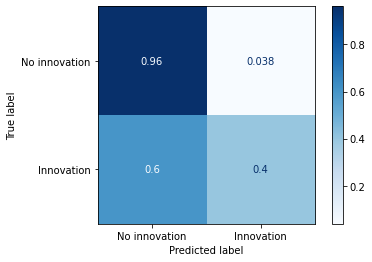

In [ ]:
# k Neighbors Classifier
knn: KNeighborsClassifier = KNeighborsClassifier()

knn.fit(X_train, y_train)
y_hat_test: np.ndarray = knn.predict(X_test)
y_hat_train: np.ndarray = knn.predict(X_train)

train_f1: float = f1_score(y_train, y_hat_train)
test_f1: float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

# The beautiful checkerboard
plot_confusion_matrix(knn, X_test, y_test, cmap='Blues', normalize='true',
                      display_labels=['No innovation', 'Innovation'])

Train f1 Score: 0.9209302325581395
Test f1 Score: 0.8759124087591241


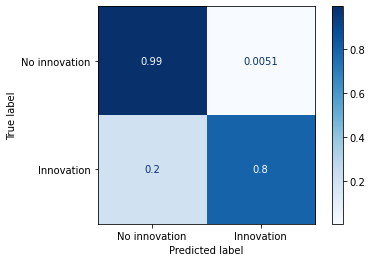

In [ ]:
# Support vector machine
svc = svm.SVC(C=4, kernel='linear', probability=True)

svc.fit(X_train, y_train)
y_hat_test: np.ndarray = svc.predict(X_test)
y_hat_train: np.ndarray = svc.predict(X_train)

train_f1: float = f1_score(y_train, y_hat_train)
test_f1: float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

# The beautiful checkerboard
plot_confusion_matrix(svc, X_test, y_test, cmap='Blues', normalize='true',
                      display_labels=['No innovation', 'Innovation'])

Train f1 Score: 1.0
Test f1 Score: 0.9932885906040269


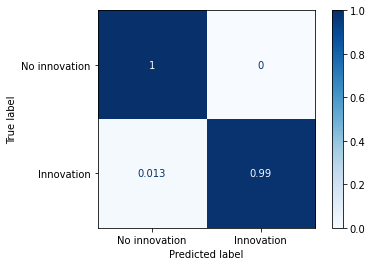

In [ ]:
# SGD classifier
clf = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-3, loss='log'))

clf.fit(X_train, y_train)
y_hat_test: np.ndarray = clf.predict(X_test)
y_hat_train: np.ndarray = clf.predict(X_train)

train_f1: float = f1_score(y_train, y_hat_train)
test_f1: float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

# The beautiful checkerboard
plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', normalize='true',
                      display_labels=['No innovation', 'Innovation'])

In [ ]:
# Generate probabilities for each prediction
clf.predict_proba(X_test)

array([[9.99989556e-01, 1.04439483e-05],
       [9.99988970e-01, 1.10298671e-05],
       [9.99991749e-01, 8.25051944e-06],
       [9.99989459e-01, 1.05414621e-05],
       [9.99992672e-01, 7.32836298e-06],
       [9.99993516e-01, 6.48351495e-06],
       [5.54938444e-01, 4.45061556e-01],
       [9.99955776e-01, 4.42244128e-05],
       [9.99992848e-01, 7.15163523e-06],
       [9.99993378e-01, 6.62154181e-06],
       [9.99993474e-01, 6.52583100e-06],
       [0.00000000e+00, 1.00000000e+00],
       [9.99989920e-01, 1.00796784e-05],
       [9.99931875e-01, 6.81250843e-05],
       [1.33957144e-07, 9.99999866e-01],
       [9.77855087e-04, 9.99022145e-01],
       [9.99986677e-01, 1.33232851e-05],
       [9.99989890e-01, 1.01096993e-05],
       [1.08200052e-07, 9.99999892e-01],
       [9.99992884e-01, 7.11583444e-06],
       [9.99986742e-01, 1.32582325e-05],
       [9.99990138e-01, 9.86162077e-06],
       [9.99989235e-01, 1.07652102e-05],
       [9.99988277e-01, 1.17232305e-05],
       [9.999900

## After decision, train first classifier

We classify all the data for which the model is more than 99% certain of its response. We use 2 differents models to classifie with 99% safety and a last model differents of the first two with 50% of safety for classifie all the rest of data.

In [ ]:
# Initiate iteration counter
iterations: int = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s: list = []
test_f1s: list = []
pseudo_labels: list = []

# Assign value to initiate while loop
high_prob: list = [1]

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:

    # Fit classifier and make train/test predictions
    log: LogisticRegression = LogisticRegression(C=1e5)
    log.fit(X_train, y_train)
    y_hat_train: np.ndarray = log.predict(X_train)
    y_hat_test: np.ndarray = log.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    train_f1: float = f1_score(y_train, y_hat_train)
    test_f1: float = f1_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)

    if (len(X_unlabeled) > 0):
        # Generate predictions and probabilities for unlabeled data
        print(f"Now predicting labels for unlabeled data...")

        pred_probs: np.ndarray = log.predict_proba(X_unlabeled)
        preds: np.ndarray = log.predict(X_unlabeled)
        prob_0: list = pred_probs[:, 0]
        prob_1: list = pred_probs[:, 1]

        # Store predictions and probabilities in dataframe
        df_pred_prob: pd.DataFrame = pd.DataFrame([])
        df_pred_prob['preds']: pd.DataFrame = preds
        df_pred_prob['prob_0']: pd.DataFrame = prob_0
        df_pred_prob['prob_1']: pd.DataFrame = prob_1
        df_pred_prob.index: pd.DataFrame = X_unlabeled.index

        # Separate predictions with > 99% probability
        high_prob: pd.DataFrame = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.99],
                                             df_pred_prob.loc[df_pred_prob['prob_1'] > 0.99]],
                                            axis=0)

        print(f"{len(high_prob)} high-probability predictions added to training data.")

        pseudo_labels.append(len(high_prob))

        # Add pseudo-labeled data to training data
        X_train: pd.DataFrame = pd.concat(
            [X_train, X_unlabeled.loc[high_prob.index]], axis=0)
        y_train: pd.DataFrame = pd.concat([y_train, high_prob.preds])

        # Drop pseudo-labeled instances from unlabeled data
        X_unlabeled: pd.DataFrame = X_unlabeled.drop(index=high_prob.index)
        print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")

        # Update iteration counter
        iterations += 1
    else:
        high_prob: list = []
        print(f'end of process.')

Iteration 0
Train f1: 0.9985096870342772
Test f1: 1.0
Now predicting labels for unlabeled data...
5172 high-probability predictions added to training data.
26 unlabeled instances remaining.

Iteration 1
Train f1: 0.9997262523952916
Test f1: 1.0
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
26 unlabeled instances remaining.



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



## Train Second classifier for the last unlabelled data

In [ ]:
# Initiate iteration counter
iterations: float = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s: list = []
test_f1s: list = []
pseudo_labels: list = []

# Assign value to initiate while loop
high_prob: list = [1]

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:

    # Fit classifier and make train/test predictions
    knn: KNeighborsClassifier = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    y_hat_train: np.ndarray = knn.predict(X_train)
    y_hat_test: np.ndarray = knn.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    train_f1: float = f1_score(y_train, y_hat_train)
    test_f1: float = f1_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)

    if (len(X_unlabeled) > 0):
        # Generate predictions and probabilities for unlabeled data
        print(f"Now predicting labels for unlabeled data...")

        pred_probs: np.ndarray = knn.predict_proba(X_unlabeled)
        preds: np.ndarray = knn.predict(X_unlabeled)
        prob_0: list = pred_probs[:, 0]
        prob_1: list = pred_probs[:, 1]

        # Store predictions and probabilities in dataframe
        df_pred_prob: pd.DataFrame = pd.DataFrame([])
        df_pred_prob['preds']: pd.DataFrame = preds
        df_pred_prob['prob_0']: pd.DataFrame = prob_0
        df_pred_prob['prob_1']: pd.DataFrame = prob_1
        df_pred_prob.index: pd.DataFrame = X_unlabeled.index

        # Separate predictions with > 99% probability
        high_prob: pd.DataFrame = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.99],
                                             df_pred_prob.loc[df_pred_prob['prob_1'] > 0.99]],
                                            axis=0)

        print(f"{len(high_prob)} high-probability predictions added to training data.")

        pseudo_labels.append(len(high_prob))

        # Add pseudo-labeled data to training data
        X_train: pd.DataFrame = pd.concat(
            [X_train, X_unlabeled.loc[high_prob.index]], axis=0)
        y_train: pd.DataFrame = pd.concat([y_train, high_prob.preds])

        # Drop pseudo-labeled instances from unlabeled data
        X_unlabeled: pd.DataFrame = X_unlabeled.drop(index=high_prob.index)
        print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")

        # Update iteration counter
        iterations += 1
    else:
        high_prob: list = []
        print(f'end of process.')

Iteration 0
Train f1: 0.7601572739187418
Test f1: 0.6071428571428572
Now predicting labels for unlabeled data...
14 high-probability predictions added to training data.
12 unlabeled instances remaining.

Iteration 1
Train f1: 0.7601572739187418
Test f1: 0.6071428571428572
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
12 unlabeled instances remaining.



In [ ]:
# Plot f1 scores and number of pseudo-labels added for all iterations
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))
ax1.plot(range(iterations), test_f1s)
ax1.set_ylabel('f1 Score')
ax2.bar(x=range(iterations), height=pseudo_labels)
ax2.set_ylabel('Pseudo-Labels Created')
ax2.set_xlabel('# Iterations')

# View confusion matrix after self-training
plot_confusion_matrix(knn, X_test, y_test, cmap='Blues', normalize='true',
                      display_labels=['No Innovation', 'Innovation'])

## If needed, third classifier

In [ ]:
# Initiate iteration counter
iterations: int = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s: list = []
test_f1s: list = []
pseudo_labels: list = []

# Assign value to initiate while loop
high_prob: list = [1]

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:

    # Fit classifier and make train/test predictions
    clf = make_pipeline(StandardScaler(),
                        SGDClassifier(max_iter=1000, tol=1e-3, loss='log'))
    clf.fit(X_train, y_train)
    y_hat_train: np.ndarray = clf.predict(X_train)
    y_hat_test: np.ndarray = clf.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    train_f1: float = f1_score(y_train, y_hat_train)
    test_f1: float = f1_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)

    if (len(X_unlabeled) > 0):
        # Generate predictions and probabilities for unlabeled data
        print(f"Now predicting labels for unlabeled data...")

        pred_probs: np.ndarray = clf.predict_proba(X_unlabeled)
        preds: np.ndarray = clf.predict(X_unlabeled)
        prob_0: list = pred_probs[:, 0]
        prob_1: list = pred_probs[:, 1]

        # Store predictions and probabilities in dataframe
        df_pred_prob: pd.DataFrame = pd.DataFrame([])
        df_pred_prob['preds']: pd.DataFrame = preds
        df_pred_prob['prob_0']: pd.DataFrame = prob_0
        df_pred_prob['prob_1']: pd.DataFrame = prob_1
        df_pred_prob.index: pd.DataFrame = X_unlabeled.index

        # Separate predictions with > 60% probability
        high_prob: pd.DataFrame = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.60],
                                             df_pred_prob.loc[df_pred_prob['prob_1'] > 0.60]],
                                            axis=0)

        print(f"{len(high_prob)} high-probability predictions added to training data.")

        pseudo_labels.append(len(high_prob))

        # Add pseudo-labeled data to training data
        X_train: pd.DataFrame = pd.concat(
            [X_train, X_unlabeled.loc[high_prob.index]], axis=0)
        y_train: pd.DataFrame = pd.concat([y_train, high_prob.preds])

        # Drop pseudo-labeled instances from unlabeled data
        X_unlabeled: pd.DataFrame = X_unlabeled.drop(index=high_prob.index)
        print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")

        # Update iteration counter
        iterations += 1
    else:
        high_prob: list = []
        print(f'end of process.')

Iteration 0
Train f1: 1.0
Test f1: 1.0
Now predicting labels for unlabeled data...
12 high-probability predictions added to training data.
0 unlabeled instances remaining.

Iteration 1
Train f1: 1.0
Test f1: 1.0
end of process.


## Recuperate data, analyse results and export results

In [ ]:
X_test['innovation_detection']: pd.DataFrame = y_test
test_end: pd.DataFrame = X_test

In [ ]:
X_train['innovation_detection']: pd.DataFrame = y_train
train_end: pd.DataFrame = X_train

In [ ]:
final: pd.DataFrame = pd.concat([train_end, test_end])

In [ ]:
final['index']: pd.DataFrame = final.index

In [ ]:
df_final: pd.DataFrame = pd.merge(
    left=df, right=final, left_on='index', right_on='index')

In [ ]:
df_final: pd.DataFrame = df_final.rename(columns={'art_id_x': 'art_id',
                                                  'innovation_detection_y': 'innovation_features'})

In [ ]:
data_acp: pd.DataFrame = df_final[['Nb_key_words_x', 'Nb_key_words_title_x',
                                   'ratio_key_words_x', 'ratio_key_word_title_x']]
y: pd.DataFrame = df_final['innovation_features']
dic_values: dict = {"Innovation": 1, "No Innovation": 0}

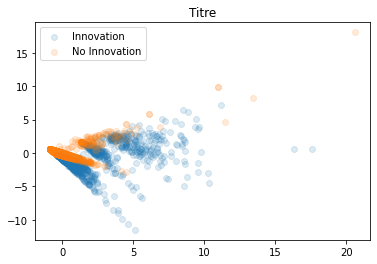

In [ ]:
# Graph 2D for see predictions
graph_2d(data_acp, y, dic_values)

In [ ]:
# Graph 3D for see predictions
graph_3d(data_acp, y, dic_values)

In [ ]:
df_final: pd.DataFrame = df_final[['art_id', 'innovation_features']]

In [ ]:
df_final.to_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/Res_Innovation_semi_supervised_V0.json")

# Method 2 (v1):

This document is a notebook who try to define if a document talk about the "innovation" or "management range" theme. We use the same processus as V0, because we define a function who seperate documents which we are sure they are talking about innovation (or management range) and the documents we are sure they don't talk about about inovation(or management range). With documents classifie as innovation(or management range) or not, we make labels at the others who are not classifie by function using semi-supervised methods. For training our models, we use the Bag Of Words given by G3 unlike to the V0 where we use the features. We have improved our word list, our function to define innovations (management range), our prediction algorithms for have the best predictions. We made many graphics for see our results and improve then, but as not to encumber the document, I do not present them here.

## Functions

In [ ]:
# Count the number of distinct words in each documents
def count_words_diff(df: pd.DataFrame, list_key: list) -> list:
    """Documentation
    Parameter:
        df: Column who contain text of article
        list_key: List of key words

    Out:
        result: Lenght of all dictionary by article, who represents the number of distinct words
    """
    result: list = []
    for j in tqdm(range(len(df))):
        liste: list = df[j].split()
        dico: dict = {}
        fait: bool = False
        for i in range(len(liste)):
            try:
                if (liste[i]+' '+liste[i+1]+' '+liste[i+2]) in list_key:
                    dic(liste[i]+' '+liste[i+1]+' '+liste[i+2], dico)
                    fait = True
                else:
                    try:
                        if (liste[i]+' '+liste[i+1]) in list_key:
                            dic(liste[i]+' '+liste[i+1], dico)
                            fait = True
                    except:
                        pass
            except:
                pass
            if not fait:
                dic(liste[i], dico)
            fait = False
        result.append(len(dico))

    return result

In [ ]:
# Return a dico with all the distinct word and their numbers of appearances
def comparaison_words_diff(texte: str, list_key: list) -> dict:
    """Documentation
    Parameter:
        texte: Text of an article
        list_key: List of key words

    Out:
        dico: A dictionnary of all words presents in documents with numbers of their apparition
    """
    liste: list = texte.split()
    dico: dict = {}
    fait: bool = False
    for i in range(len(liste)):
    try:
        if (liste[i]+' '+liste[i+1]+' '+liste[i+2]) in list_key:
            dic(liste[i]+' '+liste[i+1]+' '+liste[i+2], dico)
            fait = True
        else:
            try:
                if (liste[i]+' '+liste[i+1]) in list_key:
                    dic(liste[i]+' '+liste[i+1], dico)
                    fait = True
            except:
                pass
    except:
        pass
    if not fait:
        dic(liste[i], dico)
    fait = False

    return dico

In [ ]:
# count the distinct word of a list
def count_key_words_diff(liste: list) -> dict:
    """Documentation
    Parameter:
        liste: List of key words

    Out:
        dico: Dictionnary with all key words in list
    """
    dico: dict = {}
    for i in range(len(liste)):
        dic(liste[i], dico)

    return (dico)

In [ ]:
# Look up a word in a dictionary
def dic(term: str, dico: dict):
    """Documentation
    Parameters:
        term: One or set of words
        dico: Dictionary
    """
    if term in dico.keys():
        dico[term] += 1
    elif term != '':
        dico[term] = 1

In [ ]:
# Count the number of distinct key words of a list present in each text
def key_word_in_doc(df: pd.DataFrame, list_key: list) -> list:
    """Documentation
    Parameters:
        df: Column of dataframe who contains all text
        list_key: List of keys word

    Out:
        key_word: List of key words
    """
    key_word: list = []
    for i in tqdm(range(len(df))):
        sortie: dict = comparaison_words_diff(df[i], list_key)
        liste_cle: list = []
        for cle in sortie.keys():
            liste_cle.append(cle)
        tot: int = 0
        for i in liste_cle:
            if i in (list_key.tolist()):
                tot = tot + 1
        key_word.append(tot)

    return (key_word)

In [ ]:
# Use to generate weighted randomness to say if a document talk about management range or not
def score_to_threshold(x: int) -> int:
    """Documentation
    Parameters:
        x: Innovation score associated with an article
    Out:
        Threshold probability used to differentiate innovative from non-innovative documents
    """

    return np.arctan(x * 100) / np.pi * 2 * 0.2 + 0.8

In [ ]:
# Function to tell if a document talk about management range or not
def gestion(data_nb1: pd.DataFrame, data_nb2: pd.DataFrame, data_nb3: pd.DataFrame, data_ratio1: pd.DataFrame, data_ratio2: pd.DataFrame, data_ratio3: pd.DataFrame) -> list:
    """Documentation  
    Parameters:
        data_nb1: First column of a dataframe who describe a number of key words presents in text
        data_nb2: Second column of a dataframe who describe a number of key words presents in title
        data_nb3: Third column who describe the distinct number of key word presents in text
        data_ratio1: Linked column of data_nb1 who represents a ratio of key word apparition in text
        compared to the total number of words in text
        data_ratio2: Linked column of data_nb2 who represents a ratio of key word apparition in title
        compared to the total number of words in title
        data_ratio3: Linked column of data_nb3 who represents a ratio of distinct key word apparition in text
        compared to the total number of distinct word in text

    Out:
        list: Represents whether a document is innovative or not (i.e. yes = 1, no = 0, don't know = ?)
    """
    res: list = []
    seuil: float = 0.70

    # The higher score show document who talk about management range and the weakest show document who don't talk about management range
    for i in tqdm(range(len(data_nb1))):
        valeur = 0.5*(data_nb1[i]*data_ratio1[i]) + 0.5 * \
            (data_nb2[i]*data_ratio2[i]) + (data_nb3[i]*data_ratio3[i])
        alea: float = np.random.random()
        # We define a threshold and the document who have a score higher of this threshold take a 1 who represent management range
        if valeur > seuil:
            res.append(1)
        # Documents whith little score are consider such as they don't talk about management range take 0
        elif (valeur < seuil) & (data_nb1[i] == 0) & (data_nb2[i] == 0):
            res.append(0)
        elif (valeur < seuil) & (data_ratio1[i] < 0.0002) & (data_ratio2[i] < 0.0005):
            res.append(0)
        else:
            if valeur > seuil / 2 and alea > score_to_threshold((seuil - valeur)):
                res.append(1)
            elif valeur < seuil / 2 and alea > score_to_threshold(valeur):
                res.append(0)
            # The others have a '?' because we don't know if they talk about management range or not and we try in the rest of notebooks to create labels
            # for the documents with '?' thanks to documents who have labels
            else:
                res.append('?')

    return res

In [ ]:
# Function use to create all features we need
def create_features(df: pd.DataFrame, texte: str, title: str, inno_ges: str) -> pd.DataFrame:
    """Documentation
    Parameters:
        df: A dataframe on which we will create features
        texte: Name of column who contain text
        title: Name of column who contain title of article
        inno_ges: String to specify if we want an analyse on management range or innovation
        We can only choose options "innovation" or "gestion"

    Out:
        df: Dataframe with informations
    """
    if (inno_ges == 'innovation'):
        df_lexique: pd.DataFrame = df_lexique_innovation
    elif (inno_ges == 'gestion'):
        df_lexique: pd.DataFrame = df_lexique_gestion

    df["nb_key_words"]: pd.DataFrame = count_key_words(
        df[texte], df_lexique["key_words_lemma"])
    df["nb_key_words_title"]: pd.DataFrame = count_key_words(
        df[title], df_lexique["key_words_lemma"])
    df["nb_words"]: pd.DataFrame = nb_word(df[texte])
    df["nb_words_title"]: pd.DataFrame = nb_word(df[title])
    df["nb_sentences"]: pd.DataFrame = sentences(df, texte)
    df["average_word_sentence"]: pd.DataFrame = df["nb_words"] / df["nb_sentences"]
    df["ratio_word_title_on_word"]: pd.DataFrame = df["nb_words_title"] / df["nb_words"]
    df['ratio_key_words']: pd.DataFrame = df['nb_key_words']/df['nb_words']
    df['ratio_key_words']: pd.DataFrame = df['ratio_key_words'].fillna(0)
    df['ratio_key_sentences']: pd.DataFrame = df['nb_key_words']/df['nb_sentences']
    df['ratio_key_sentences']: pd.DataFrame = df['ratio_key_sentences'].fillna(
        0)
    df['ratio_key_word_title']: pd.DataFrame = df['nb_key_words_title'] / \
        df['nb_words_title']
    df['ratio_key_word_title']: pd.DataFrame = df['ratio_key_word_title'].fillna(
        0)
    df['word_key_diff']: pd.DataFrame = key_word_in_doc(
        df['art_lemma'], df_lexique['key_words_lemma'])
    df['word_diff']: pd.DataFrame = count_words_diff(
        df['art_lemma'], df_lexique['key_words_lemma'])
    df['ratio_key_word_diff']: pd.DataFrame = df['word_key_diff'] / df['word_diff']

    return df

In [ ]:
# Function use for create a label for each documents
def create_label(df: pd.DataFrame, features: list, inno_ges: str, texte: str, title: str):
    """Documentation
    Parameters:
        df: A dataframe who contains article that we are going to classify
        features: Features we want to use for training our model.
        texte: Name of column who contain text
        title: Name of column who contain title of article
        inno_ges: String to specify if we want an analyse on management range or innovation.
        We can only choose options "innovation" or "gestion"

    Out: 
        df_final: Dataframe with a label for each documents
    """
    df: pd.DataFrame = create_features(df, texte, title, inno_ges)

    if (inno_ges == 'innovation'):
        df['prediction_supervise']: pd.DataFrame = innovation(
            df['nb_key_words'], df['nb_key_words_title'], df['word_key_diff'], df['ratio_key_words'], df['ratio_key_word_title'], df['ratio_key_word_diff'])
    elif (inno_ges == 'gestion'):
        df['prediction_supervise']: pd.DataFrame = gestion(
            df['nb_key_words'], df['nb_key_words_title'], df['word_key_diff'], df['ratio_key_words'], df['ratio_key_word_title'], df['ratio_key_word_diff'])

    df: pd.DataFrame = df.sample(
        frac=1, random_state=15).reset_index(drop=True)
    df['index']: pd.DataFrame = df.index

    var_useful: pd.DataFrame = df[features]
    var_useful: pd.DataFrame = pd.concat(
        [var_useful, df['prediction_supervise']], axis=1)

    all: pd.DataFrame = var_useful[var_useful['prediction_supervise'] != '?']
    unlabeled: pd.DataFrame = var_useful[var_useful['prediction_supervise'] == '?']

    X_train: pd.DataFrame = all.drop('prediction_supervise', axis=1)
    y_train: pd.DataFrame = all.prediction_supervise
    y_train: pd.DataFrame = pd.to_numeric(y_train)

    X_unlabeled: pd.DataFrame = unlabeled.drop('prediction_supervise', axis=1)

    if (inno_ges == 'innovation'):
        model1 = svm.SVC(C=3, kernel='linear', probability=True)
        model2: LogisticRegression = LogisticRegression(
            penalty='l1', solver='liblinear')
        model3: XGBClassifier = XGBClassifier()
    elif (inno_ges == 'gestion'):
        model1: XGBClassifier = XGBClassifier()
        model2: LogisticRegression = LogisticRegression(
            penalty='l1', solver='liblinear')
        model3 = svm.SVC(C=4, kernel='linear', probability=True)
    # Initiate iteration counter
    iterations: int = 0

    # Containers to hold f1_scores and # of pseudo-labels
    train_f1s: list = []
    pseudo_labels: list = []

    # Assign value to initiate while loop
    high_prob: list = [1]

    # Loop will run until there are no more high-probability pseudo-labels
    while len(high_prob) > 0:

        # Fit classifier and make train/test predictions
        model1.fit(X_train, y_train)
        y_hat_train: np.ndarray = model1.predict(X_train)

        # Calculate and print iteration # and f1 scores, and store f1 scores
        train_f1: float = f1_score(y_train, y_hat_train)
        print(f"Iteration {iterations}")
        print(f"Train f1: {train_f1}")
        train_f1s.append(train_f1)

        if (len(X_unlabeled) > 0):
            # Generate predictions and probabilities for unlabeled data
            print(f"Now predicting labels for unlabeled data...")

            pred_probs: np.ndarray = model1.predict_proba(X_unlabeled)
            preds: np.ndarray = model1.predict(X_unlabeled)
            prob_0: list = pred_probs[:, 0]
            prob_1: list = pred_probs[:, 1]

            # Store predictions and probabilities in dataframe
            df_pred_prob: pd.DataFrame = pd.DataFrame([])
            df_pred_prob['preds']: pd.DataFrame = preds
            df_pred_prob['prob_0']: pd.DataFrame = prob_0
            df_pred_prob['prob_1']: pd.DataFrame = prob_1
            df_pred_prob.index: pd.DataFrame = X_unlabeled.index

            # Separate predictions with > 99% probability
            high_prob: pd.DataFrame = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.99],
                                                 df_pred_prob.loc[df_pred_prob['prob_1'] > 0.99]],
                                                axis=0)
            print(
                f"{len(high_prob)} high-probability predictions added to training data.")

            pseudo_labels.append(len(high_prob))

            # Add pseudo-labeled data to training data
            X_train: pd.DataFrame = pd.concat(
                [X_train, X_unlabeled.loc[high_prob.index]], axis=0)
            y_train: pd.DataFrame = pd.concat([y_train, high_prob.preds])

            # Drop pseudo-labeled instances from unlabeled data
            X_unlabeled: pd.DataFrame = X_unlabeled.drop(index=high_prob.index)
            print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")

            # Update iteration counter
            iterations += 1
        else:
            high_prob: list = []
            print(f'end of process.')

    # Initiate iteration counter
    iterations: int = 0

    # Containers to hold f1_scores and # of pseudo-labels
    train_f1s: list = []
    pseudo_labels: list = []

    # Assign value to initiate while loop
    high_prob: list = [1]

    # Loop will run until there are no more high-probability pseudo-labels
    while len(high_prob) > 0:

        # Fit classifier and make train/test predictions
        model2.fit(X_train, y_train)
        y_hat_train: np.ndarray = model2.predict(X_train)

        # Calculate and print iteration # and f1 scores, and store f1 scores
        train_f1: float = f1_score(y_train, y_hat_train)
        print(f"Iteration {iterations}")
        print(f"Train f1: {train_f1}")
        train_f1s.append(train_f1)

        if (len(X_unlabeled) > 0):
            # Generate predictions and probabilities for unlabeled data
            print(f"Now predicting labels for unlabeled data...")

            pred_probs: np.ndarray = model2.predict_proba(X_unlabeled)
            preds: np.ndarray = model2.predict(X_unlabeled)
            prob_0: list = pred_probs[:, 0]
            prob_1: list = pred_probs[:, 1]

            # Store predictions and probabilities in dataframe
            df_pred_prob: pd.DataFrame = pd.DataFrame([])
            df_pred_prob['preds']: pd.DataFrame = preds
            df_pred_prob['prob_0']: pd.DataFrame = prob_0
            df_pred_prob['prob_1']: pd.DataFrame = prob_1
            df_pred_prob.index: pd.DataFrame = X_unlabeled.index

            # Separate predictions with > 99% probability
            high_prob: pd.DataFrame = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.99],
                                                 df_pred_prob.loc[df_pred_prob['prob_1'] > 0.99]],
                                                axis=0)
            print(
                f"{len(high_prob)} high-probability predictions added to training data.")

            pseudo_labels.append(len(high_prob))

            # Add pseudo-labeled data to training data
            X_train: pd.DataFrame = pd.concat(
                [X_train, X_unlabeled.loc[high_prob.index]], axis=0)
            y_train: pd.DataFrame = pd.concat([y_train, high_prob.preds])

            # Drop pseudo-labeled instances from unlabeled data
            X_unlabeled: pd.DataFrame = X_unlabeled.drop(index=high_prob.index)
            print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")

            # Update iteration counter
            iterations += 1
        else:
            high_prob: list = []
            print(f'end of process.')

    # Initiate iteration counter
    iterations: int = 0

    # Containers to hold f1_scores and # of pseudo-labels
    train_f1s: list = []
    pseudo_labels: list = []

    # Assign value to initiate while loop
    high_prob: list = [1]

    # Loop will run until there are no more high-probability pseudo-labels
    while len(high_prob) > 0:

        # Fit classifier and make train/test predictions
        model3.fit(X_train, y_train)
        y_hat_train: np.ndarray = model3.predict(X_train)

        # Calculate and print iteration # and f1 scores, and store f1 scores
        train_f1: float = f1_score(y_train, y_hat_train)
        print(f"Iteration {iterations}")
        print(f"Train f1: {train_f1}")
        train_f1s.append(train_f1)

        if (len(X_unlabeled) > 0):
            # Generate predictions and probabilities for unlabeled data
            print(f"Now predicting labels for unlabeled data...")

            pred_probs: np.ndarray = model3.predict_proba(X_unlabeled)
            preds: np.ndarray = model3.predict(X_unlabeled)
            prob_0: list = pred_probs[:, 0]
            prob_1: list = pred_probs[:, 1]

            # Store predictions and probabilities in dataframe
            df_pred_prob: pd.DataFrame = pd.DataFrame([])
            df_pred_prob['preds']: pd.DataFrame = preds
            df_pred_prob['prob_0']: pd.DataFrame = prob_0
            df_pred_prob['prob_1']: pd.DataFrame = prob_1
            df_pred_prob.index: pd.DataFrame = X_unlabeled.index

            # Separate predictions with > 60% probability
            high_prob: pd.DataFrame = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.50],
                                                 df_pred_prob.loc[df_pred_prob['prob_1'] > 0.50]],
                                                axis=0)
            print(
                f"{len(high_prob)} high-probability predictions added to training data.")

            pseudo_labels.append(len(high_prob))

            # Add pseudo-labeled data to training data
            X_train: pd.DataFrame = pd.concat(
                [X_train, X_unlabeled.loc[high_prob.index]], axis=0)
            y_train: pd.DataFrame = pd.concat([y_train, high_prob.preds])

            # Drop pseudo-labeled instances from unlabeled data
            X_unlabeled: pd.DataFrame = X_unlabeled.drop(index=high_prob.index)
            print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")

            # Update iteration counter
            iterations += 1
        else:
            high_prob: list = []
            print(f'end of process.')

    X_train['prediction_supervise']: pd.DataFrame = y_train
    X_train['index']: pd.DataFrame = X_train.index
    df_final: pd.DataFrame = pd.merge(
        left=df, right=X_train, left_on='index', right_on='index')
    df_final: pd.DataFrame = df_final[['art_id', 'prediction_supervise_y']]
    df_final: pd.DataFrame = df_final.rename(
        columns={'prediction_supervise_y': 'prediction_supervise'})

    return df_final

## Results analysis

In [ ]:
v0: pd.DataFrame = pd.read_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/Res_Innovation_semi_supervised_Feature.json")

data0: pd.DataFrame = pd.read_csv(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/Data_With_Features_Syntax.csv")

df0 = pd.merge(left=data0, right=v0, on='art_id')

df_innovant_v0 = df0[df0['innovation_features'] == 1].reset_index()
df_non_innovant_v0 = df0[df0['innovation_features'] == 0].reset_index()

In [ ]:
gestion: pd.DataFrame = pd.read_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/Res_gestion_semi_supervised_V1_boost.json")
bow: pd.DataFrame = pd.read_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/Res_Innovation_semi_supervised_bow_V1.json")
word2vec: pd.DataFrame = pd.read_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/Res_Innovation_semi_supervised_word2vec_V1.json")

df2 = pd.merge(left=data0, right=gestion, on='art_id')
df3 = pd.merge(left=data0, right=bow, on='art_id')
df4 = pd.merge(left=data0, right=word2vec, on='art_id')

df_gestion = df2[df2['gamme_gestion'] == 1]
df_gestion = df_gestion.reset_index()

df_innovant_bow = df3[df3['innovation_detection_bow'] == 1]
df_innovant_bow = df_innovant_bow.reset_index()

df_innovant_word2vec = df4[df4['innovation_detection_bow'] == 1]
df_innovant_word2vec = df_innovant_word2vec.reset_index()

df_non_gestion = df2[df2['gamme_gestion'] == 0]
df_non_gestion = df_non_gestion.reset_index()

df_non_innovant_bow = df3[df3['innovation_detection_bow'] == 0]
df_non_innovant_bow = df_non_innovant_bow.reset_index()

df_non_innovant_word2vec = df4[df4['innovation_detection_bow'] == 0]
df_non_innovant_word2vec = df_non_innovant_word2vec.reset_index()

In [ ]:
function_gestion_1: pd.DataFrame = pd.read_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/fonction_gestion.json")
function_innovation_1: pd.DataFrame = pd.read_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/fonction_innovation.json")
function_gestion_0: pd.DataFrame = pd.read_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/fonction_non_gestion.json")
function_innovation_0: pd.DataFrame = pd.read_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/fonction_non_innovation.json")

df5 = pd.merge(left=data0, right=function_gestion_1, on='art_id')
df6 = pd.merge(left=data0, right=function_innovation_1, on='art_id')
df7 = pd.merge(left=data0, right=function_gestion_0, on='art_id')
df8 = pd.merge(left=data0, right=function_innovation_0, on='art_id')

df_innovant_function_gestion_1 = df5[df5['gestion_detection'] == 1].reset_index(
)
df_innovant_function_innovation_1 = df6[df6['innovation_detection'] == 1].reset_index(
)

df_non_innovant_function_gestion_0 = df7[df7['gestion_detection'] == 0].reset_index(
)
df_non_innovant_function_innovation_0 = df8[df8['innovation_detection'] == 0].reset_index(
)

## Word cloud on our labels given by the functions

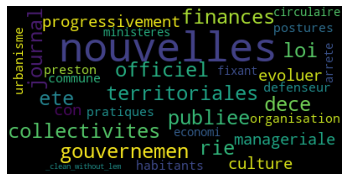

In [ ]:
# Word cloud of documents classifie as management range with function gestion
wordcloud_list_art(df_innovant_function_gestion_1.loc[:len(
    df_innovant_function_gestion_1), "art_content_clean_without_lem"])

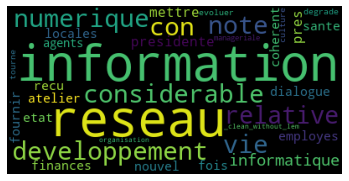

In [ ]:
# Word cloud of documents classifie as no innovant with function innovation
wordcloud_list_art(df_innovant_function_innovation_1.loc[:len(
    df_innovant_function_innovation_1), "art_content_clean_without_lem"])

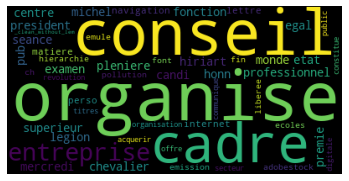

In [ ]:
# Word cloud of documents classifie as management range with function gestion
wordcloud_list_art(df_non_innovant_function_gestion_0.loc[:len(
    df_non_innovant_function_gestion_0), "art_content_clean_without_lem"])

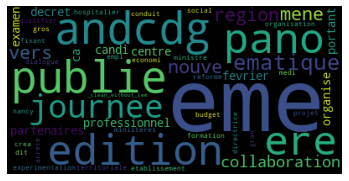

In [ ]:
# Word cloud of documents classifie as no management range with function gestion
wordcloud_list_art(df_non_innovant_function_innovation_0.loc[:len(
    df_non_innovant_function_innovation_0), "art_content_clean_without_lem"])

To resume this briefly, we can see that the results of function innovation and gestion are pretty good because innovation as many words presents in list (information, reseau, numerique, developpement...) and gestion to (finances, collectivités, urbanisme...). We can consider that the 2 functions are good for create the first labels strongly. Moreover, the results of not innovants or not gestion don't talk about them.

## Results of V0 in innovations 

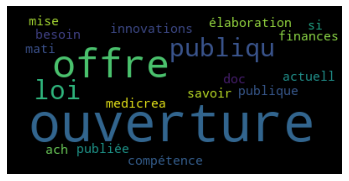

In [ ]:
# Word cloud of documents classifie as innovant with V0
wordcloud_list_art(df_innovant_v0.loc[:len(df_innovant_v0), "art_content"])

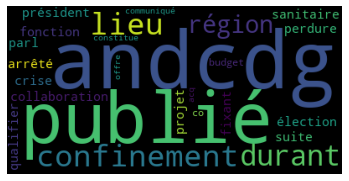

In [ ]:
# Word cloud of documents classifie as no innovant with V0
wordcloud_list_art(df_non_innovant_v0.loc[:len(
    df_non_innovant_v0), "art_content"])

V0 are not to bad, because we can see innovations, savoir or actuel in this word coud but we don't have many words and this methods can overfit on the words presents in list and we can end up with biases

## Results of V1 for gestion and innovation

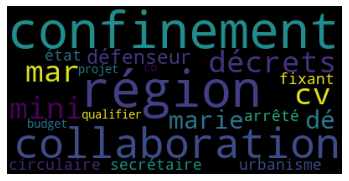

In [ ]:
# Word cloud of documents classifie as management range with bag of words
wordcloud_list_art(df_gestion.loc[:len(df_gestion), "art_content"])

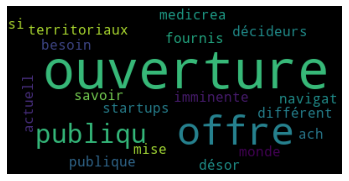

In [ ]:
# Word cloud of documents classifie as innovant with bag of words
wordcloud_list_art(df_innovant_bow.loc[:len(df_innovant_bow), "art_content"])

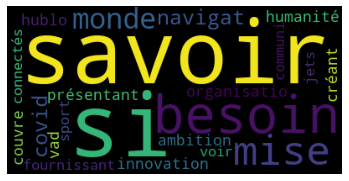

In [ ]:
# Word cloud of documents classifie as innovant with word2vec
wordcloud_list_art(df_innovant_word2vec.loc[:1200, "art_content"])

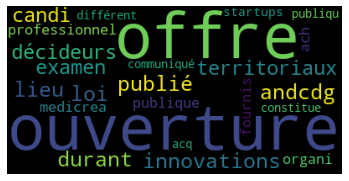

In [ ]:
# Word cloud of documents classifie as no management range with bag of words
wordcloud_list_art(df_non_gestion.loc[:len(df_non_gestion), "art_content"])

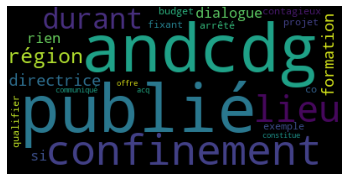

In [ ]:
# Word cloud of documents classifie as no innovant with bag of words
wordcloud_list_art(df_non_innovant_bow.loc[:len(
    df_non_innovant_bow), "art_content"])

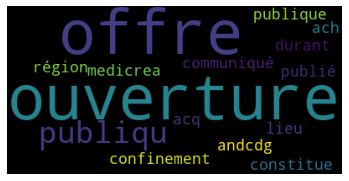

In [ ]:
# Word cloud of documents classifie as no innovant with word2vec
wordcloud_list_art(df_non_innovant_word2vec.loc[:len(
    df_non_innovant_word2vec), "art_content"])

Results for V1 in management range are very satisfying because we have many words linked to gestion and presents in list such as region, urbanisme, budget... and we mainly have words related to management not present in the list (CV, décrets, secrétaires) that is very interesting and that shows our methods is very efficient for see article linked to management range

# Conclusion

For innovations, it's a little disappointing even though we have better results than V0 because we don't have many words present in list. But, such as management range, we have words not presents in list but presents in cloud word (ouverture, décideurs, savoir) and this is also interesting and it proves that our way of doing things is right. We have better results whith Word2Vec embedddings with words like savoir, innovation or ambition who represents very well the theme of innovations. So, we thinks the embeddings representation of words is very important and for the the theme 'management range', bag of words are very efficient while for 'innovation' theme, Word2Vec gives better satisfaction